In [386]:
# This file implements a LTSM model to predict taxi demand for a given zone and time in Porto
# Some portions of this code were generated with ChatGPT (OpenAI, 2023) and are attributed inline where they appear

# References:
# OpenAI. (2023). ChatGPT (Mar 14 version) [Large language model]. https://chat.openai.com/chat

In [317]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import ast


In [318]:
# Load dataset
df = pd.read_csv("taxi_trajectories/cleaned_taxi_data.csv") 


In [319]:
# Only sample 600000 rows
df = df.sample(n=600000, random_state=1234)

In [320]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,HOUR,DAY_OF_WEEK,MONTH,TRAJECTORY_LENGTH
1335278,1399476189620000031,0,0.0,20000031,2014-05-07 15:23:09,0,"[[-8.631648, 41.15889], [-8.63181, 41.159079],...",15,NaN,5,49
568182,1383824959620000018,0,0.0,20000018,2013-11-07 11:49:19,0,"[[-8.610075, 41.152941], [-8.609967, 41.152824...",11,NaN,11,45
93529,1374414533620000393,1,15.0,20000393,2013-07-21 13:48:53,0,"[[-8.585586, 41.14845], [-8.585811, 41.148792]...",13,NaN,7,44
1266195,1398243456620000343,1,21.0,20000343,2014-04-23 08:57:36,0,"[[-8.628759, 41.160987], [-8.628678, 41.160942...",8,NaN,4,37
1334937,1399477781620000160,1,15.0,20000160,2014-05-07 15:49:41,0,"[[-8.585667, 41.148477], [-8.585658, 41.148495...",15,NaN,5,63


In [387]:
# This function was generated with help of ChatGPT (OpenAI, 2023) 
def create_zones(df, n_clusters=10):
    # Convert POLYLINE string to list of coordinates and get the first point (pickup location)
    def extract_first_point(polyline_str):
        try:
            coords = ast.literal_eval(polyline_str)  # Convert string to list
            return coords[0] if coords else [np.nan, np.nan]  # Handle empty lists
        except:
            return [np.nan, np.nan]  # Handle invalid formats
    
    # Extract pickup coordinates and keep original index
    pickup_coords = df['POLYLINE'].apply(extract_first_point)
    pickup_df = pd.DataFrame(pickup_coords.tolist(), columns=['pickup_lon', 'pickup_lat'], index=df.index)  # Retain df's original index
    print(pickup_df.head())

    # Remove coordinates outside Porto 
    def remove_non_porto(df):
        return df[(df['pickup_lat'] >= 41.0) & (df['pickup_lat'] <= 41.3) & (df['pickup_lon'] >= -8.7) & (df['pickup_lon'] <= -8.5)]
    
    # Remove rows with invalid or out-of-bound coordinates
    pickup_df = remove_non_porto(pickup_df)

    # Identify valid rows (before dropping NaN)
    valid_indices = pickup_df.dropna().index

    # Remove invalid coordinates (drop NaN values)
    valid_coords = pickup_df.dropna()

    # Ensure there is enough data to perform clustering
    if len(valid_coords) < n_clusters:
        raise ValueError("Not enough valid pickup points for clustering!")

    # Perform K-means clustering on the valid coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=n_clusters)
    clusters = kmeans.fit(valid_coords)

    # Initialize 'zone' column with -1 (indicating unassigned zone)
    df['zone'] = -1
    df['pickup_coords'] = pickup_coords  # Store the original pickup coordinates in the dataframe

    # Assign cluster labels to the valid indices in the original dataframe
    df.loc[valid_indices, 'zone'] = clusters.labels_

    # Remove rows with zone == -1 (unassigned)
    df = df[df['zone'] != -1]

    df = df.reset_index(drop=True)

    return df, kmeans


In [388]:
# This function was generated with help of ChatGPT (OpenAI, 2023) 
def group_data_by_zone_and_datetime(df):
    # Group by datetime hour and zone to get demand count
    hourly_zone_demand = df.groupby([
        pd.Grouper(key='TIMESTAMP', freq='H'),
        'zone'
    ]).size().reset_index()
    hourly_zone_demand.columns = ['TIMESTAMP', 'zone', 'demand']
    
    # Pivot table to get demand for each zone in columns
    demand_matrix = hourly_zone_demand.pivot(
        index='TIMESTAMP',
        columns='zone',
        values='demand'
    ).fillna(0)

    # Ensure the index is sorted for time series consistency
    demand_matrix = demand_matrix.sort_index()
    
    return demand_matrix

In [323]:
# this function generated via chat gpt
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    
    return np.array(sequences), np.array(targets)

In [374]:
def build_lstm_model(seq_length, n_zones, num_lags):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(seq_length, n_zones * (num_lags + 1) + 1), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(n_zones, activation='relu')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [375]:
n_clusters=5
seq_length=24
test_size=0.2
epochs=50


# Create zones
df_with_zones, kmeans = create_zones(df, n_clusters)
    

         pickup_lon  pickup_lat
1335278   -8.631648   41.158890
568182    -8.610075   41.152941
93529     -8.585586   41.148450
1266195   -8.628759   41.160987
1334937   -8.585667   41.148477
   zone           pickup_coords
0     4   [-8.631648, 41.15889]
1     0  [-8.610075, 41.152941]
2     2   [-8.585586, 41.14845]
3     4  [-8.628759, 41.160987]
4     2  [-8.585667, 41.148477]


In [326]:
# filter df_with_zones to zone 0 only and write to file
df_with_zones_0 = df_with_zones[df_with_zones['zone'] == 0]
df_with_zones_0.to_csv("taxi_trajectories/df_with_zones.csv", index=False)

   zone  pickup_lat  pickup_lon
0     0   -8.611212   41.148175
1     1   -8.667951   41.163851
2     2   -8.583358   41.154858
3     3   -8.599291   41.177272
4     4   -8.635240   41.160782


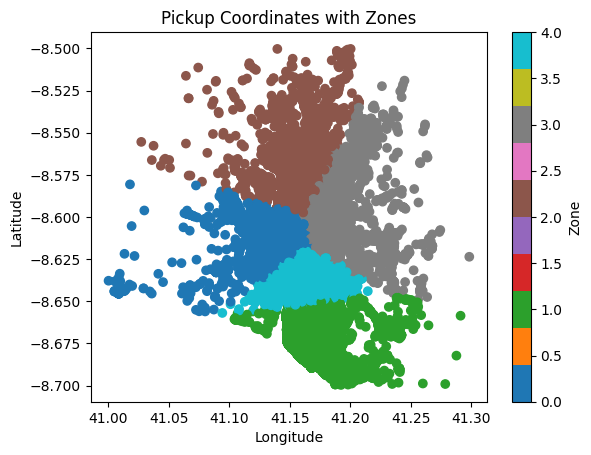

In [376]:
# Group by 'zone' to see the coordinates for each zone
df_with_zones[['pickup_lat', 'pickup_lon']] = pd.DataFrame(df_with_zones['pickup_coords'].tolist(), index=df_with_zones.index)
df_with_zones.head()

zone_coords = df_with_zones.groupby('zone').agg({'pickup_lat': 'mean', 'pickup_lon': 'mean'}).reset_index()

print(zone_coords)

import matplotlib.pyplot as plt

plt.scatter(df_with_zones['pickup_lon'], df_with_zones['pickup_lat'], c=df_with_zones['zone'], cmap='tab10')
plt.title("Pickup Coordinates with Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Zone")
plt.show()

In [377]:
# Group data by zone and datetime
df_with_zones['TIMESTAMP'] = pd.to_datetime(df_with_zones['TIMESTAMP'])
demand_matrix = group_data_by_zone_and_datetime(df_with_zones)
# Extract day of week and hour
demand_matrix['day_of_week'] = demand_matrix.index.dayofweek  # Monday=0, Sunday=6
demand_matrix['hour'] = demand_matrix.index.hour

# Create the bar_traffic flag (1 for Fri & Sat 2AM-4AM, else 0)
demand_matrix['bar_traffic'] = ((demand_matrix['day_of_week'].isin([4, 5])) &  # Friday (4) & Saturday (5)
                                (demand_matrix['hour'].between(2, 4))).astype(int)

# drop day of week and hour
demand_matrix = demand_matrix.drop(['day_of_week', 'hour'], axis=1)

print(demand_matrix.shape)
print(demand_matrix.head())

/var/folders/mv/1l8hsgqn1gg1ysw_5rvfsz7c0000gp/T/ipykernel_31373/3260074644.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(key='TIMESTAMP', freq='H'),


(8760, 6)
zone                    0    1    2    3    4  bar_traffic
TIMESTAMP                                                 
2013-07-01 00:00:00  19.0  2.0  3.0  2.0  8.0            0
2013-07-01 01:00:00  15.0  1.0  2.0  0.0  1.0            0
2013-07-01 02:00:00  13.0  2.0  2.0  2.0  5.0            0
2013-07-01 03:00:00  15.0  4.0  1.0  5.0  5.0            0
2013-07-01 04:00:00  13.0  3.0  2.0  5.0  6.0            0


In [143]:
# Scale the demand data for each zone
#scaler = MinMaxScaler()
#scaled_demand = scaler.fit_transform(demand_matrix)
    
# Create sequences
#X, y = create_sequences(scaled_demand, seq_length)
#print(X.shape, y.shape)

In [378]:
def add_lag_features(df, lags=[1, 2, 3]):
    """
    Adds lag features for demand prediction.
    
    Parameters:
    df (pd.DataFrame): Dataframe with 'TIMESTAMP' as index and demand columns per zone.
    lags (list): List of lag values (e.g., [1, 2, 3] for 1-hour, 2-hour, 3-hour lag)
    
    Returns:
    pd.DataFrame: DataFrame with additional lagged demand columns.
    """
    df_lagged = df.copy()
    
    for lag in lags:
        df_lagged[[f'lag_{lag}_zone_{col}' for col in df.columns]] = df.shift(lag)
    
    return df_lagged.dropna()  # Drop NaNs caused by shifting

demand_matrix_with_lag = add_lag_features(demand_matrix, lags=[1, 2, 3])  # Add 1-hour, 2-hour, 3-hour lags
print(demand_matrix_with_lag.shape)
#print(demand_matrix_with_lag.head())
# print the columns
print(demand_matrix_with_lag.columns)

# remove the lag columns
demand_matrix_with_lag = demand_matrix_with_lag.drop(['lag_1_zone_bar_traffic', 'lag_2_zone_bar_traffic', 'lag_3_zone_bar_traffic'], axis=1)

demand_matrix_with_lag.columns = demand_matrix_with_lag.columns.astype(str)
scaler = MinMaxScaler()
scaled_demand_with_lag = scaler.fit_transform(demand_matrix_with_lag)
    
# Create sequences
X, y = create_sequences(scaled_demand_with_lag, seq_length)
# for y select only the zone columns and not the lag columns
y = y[:, :n_clusters]
print(X.shape, y.shape)

(8757, 24)
Index([                       0,                        1,
                              2,                        3,
                              4,            'bar_traffic',
                 'lag_1_zone_0',           'lag_1_zone_1',
                 'lag_1_zone_2',           'lag_1_zone_3',
                 'lag_1_zone_4', 'lag_1_zone_bar_traffic',
                 'lag_2_zone_0',           'lag_2_zone_1',
                 'lag_2_zone_2',           'lag_2_zone_3',
                 'lag_2_zone_4', 'lag_2_zone_bar_traffic',
                 'lag_3_zone_0',           'lag_3_zone_1',
                 'lag_3_zone_2',           'lag_3_zone_3',
                 'lag_3_zone_4', 'lag_3_zone_bar_traffic'],
      dtype='object', name='zone')
(8733, 24, 21) (8733, 5)


In [379]:
demand_matrix_copy = demand_matrix.copy()

start_date = "2014-05-03"
end_date = "2014-05-05"

filtered_data = demand_matrix.loc[start_date:end_date]
print(filtered_data)

zone                     0     1     2     3     4  bar_traffic
TIMESTAMP                                                      
2014-05-03 00:00:00   42.0  12.0  13.0   6.0  20.0            0
2014-05-03 01:00:00   57.0   5.0   8.0   6.0   9.0            0
2014-05-03 02:00:00   66.0   5.0   3.0  11.0  13.0            1
2014-05-03 03:00:00  100.0   7.0   6.0   4.0   6.0            1
2014-05-03 04:00:00   78.0   3.0   4.0   7.0   8.0            1
...                    ...   ...   ...   ...   ...          ...
2014-05-05 19:00:00   30.0   5.0  14.0   7.0  14.0            0
2014-05-05 20:00:00   23.0   3.0   8.0   9.0  14.0            0
2014-05-05 21:00:00   16.0   3.0   9.0   7.0  12.0            0
2014-05-05 22:00:00   18.0   1.0   6.0  14.0   8.0            0
2014-05-05 23:00:00   27.0   6.0   5.0  26.0  18.0            0

[72 rows x 6 columns]


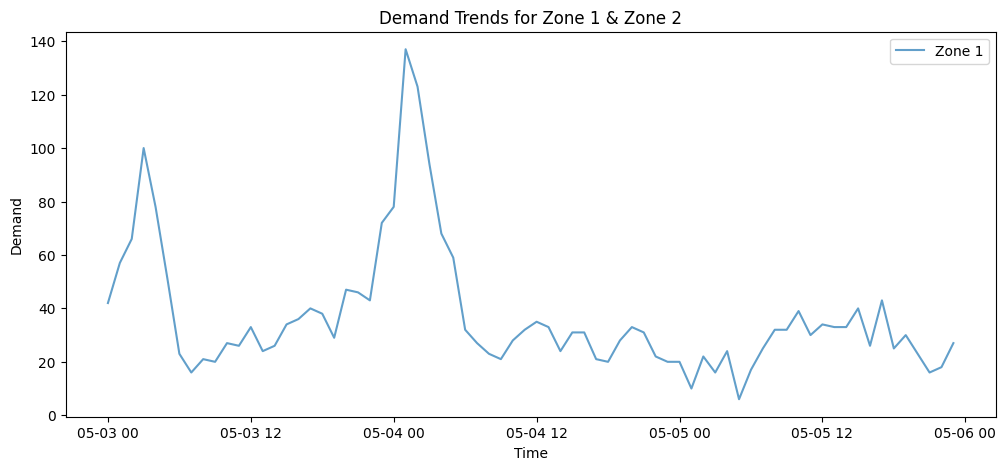

In [380]:
import matplotlib.pyplot as plt

# Plot demand over time for Zone 1 & Zone 2
plt.figure(figsize=(12, 5))
plt.plot(filtered_data.index, filtered_data[0], label="Zone 1", alpha=0.7)
#plt.plot(demand_matrix.index, demand_matrix[str(1)], label="Zone 2", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Demand Trends for Zone 1 & Zone 2")
plt.legend()
plt.show()


In [381]:
    
    # Split data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    

(6986, 24, 21) (6986, 5) (1747, 24, 21) (1747, 5)


In [382]:


# Build and train model
model = build_lstm_model(seq_length, n_clusters, num_lags=3)
    
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
    

Epoch 1/50


/Users/bosky/boskymsaiicoursework/src/module2-assginment/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 0.0377 - mae: 0.0866 - val_loss: 0.0257 - val_mae: 0.0562
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0257 - mae: 0.0568 - val_loss: 0.0255 - val_mae: 0.0593
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0246 - mae: 0.0543 - val_loss: 0.0241 - val_mae: 0.0540
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0235 - mae: 0.0517 - val_loss: 0.0238 - val_mae: 0.0533
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0235 - mae: 0.0518 - val_loss: 0.0222 - val_mae: 0.0494
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.0226 - mae: 0.0496 - val_loss: 0.0218 - val_mae: 0.0501
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.0223 - mae: 0.0488 - val_loss: 0.0214 - val_mae: 0.0483
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0213 - mae: 0.0466 - val_loss: 0.0215 - val_mae: 0.0493
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/st

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
y_test shape: (1747, 5)


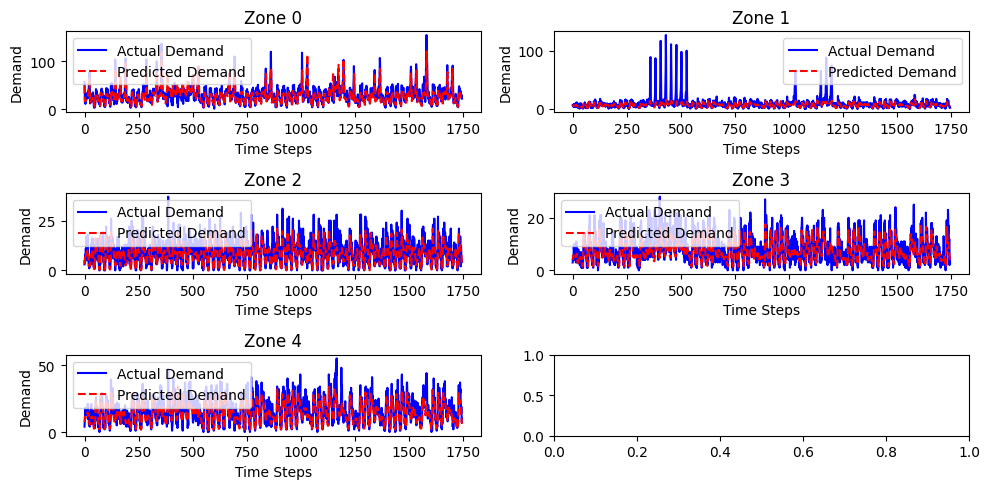

In [383]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)


print("y_test shape:", y_test.shape)
#y_test_actual = scaler.inverse_transform(y_test)

y_test_actual = scaler.inverse_transform(np.pad(y_test, ((0,0), (0,16)), 'constant')[:, :21])
y_pred_actual = scaler.inverse_transform(np.pad(y_pred, ((0,0), (0,16)), 'constant')[:, :21])
# Inverse transform the actual and predicted values (if they are scaled)
#y_test_actual = scaler.inverse_transform(y_test)  # Actual demand (inverse scaled)
#y_pred_actual = scaler.inverse_transform(y_pred)  # Predicted demand (inverse scaled)

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, n_clusters))  # Adjust figure size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot actual vs predicted for all zones
for zone_index in range(n_clusters):
    axes[zone_index].plot(y_test_actual[:, zone_index], label='Actual Demand', color='blue')
    axes[zone_index].plot(y_pred_actual[:, zone_index], label='Predicted Demand', color='red', linestyle='--')
    axes[zone_index].set_title(f'Zone {zone_index}')
    axes[zone_index].set_xlabel('Time Steps')
    axes[zone_index].set_ylabel('Demand')
    axes[zone_index].legend()

# Adjust the layout
plt.tight_layout()
plt.show()

In [385]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_per_zone = [mean_absolute_error(y_test_actual[:, i], y_pred_actual[:, i]) for i in range(n_clusters)]
print("MAE per zone:", mae_per_zone)
mse_per_zone = [mean_squared_error(y_test_actual[:, i], y_pred_actual[:, i]) for i in range(n_clusters)]
print("MSE per zone:", mse_per_zone)
rmse_per_zone = [np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_actual[:, i])) for i in range(n_clusters)]
print("RMSE per zone:", rmse_per_zone)

# Prepare the data for better formatting
rmse_per_zone_rounded = [round(rmse, 3) for rmse in rmse_per_zone]

# Create a DataFrame to display the results neatly
metrics_df = pd.DataFrame({
    'Zone': [f'Zone {i}' for i in range(n_clusters)],
    'RMSE': rmse_per_zone_rounded
})

# Display the RMSE values in a clean format
print(metrics_df)

MAE per zone: [7.061159873595563, 4.233372117596895, 3.0916573650810846, 2.605791363295788, 4.151216312483781]
MSE per zone: [101.10697383730766, 122.25189302382331, 17.363326800969844, 13.225300790874126, 32.920830095848565]
RMSE per zone: [np.float64(10.055196359957755), np.float64(11.056757798912994), np.float64(4.166932540967017), np.float64(3.6366606647959507), np.float64(5.737667652962183)]
     Zone    RMSE
0  Zone 0  10.055
1  Zone 1  11.057
2  Zone 2   4.167
3  Zone 3   3.637
4  Zone 4   5.738
